In [1]:
import cdsapi
import shutil
import os


time = [
            '00:00', '03:00', '06:00',
            '09:00', '12:00', '15:00',
            '18:00', '21:00',
]
year = [
            #'1984', '1985', '1986',
            '1987', '1988', '1989',
            '1990', '1991', '1992',
            '1993', '1994', '1995',
            '1996', '1997', '1998',
            '1999', '2000', '2001',
            '2002', '2003', '2004',
            '2005', '2006', '2007',
            '2008', '2009', '2010',
            '2011', '2012', '2013',
            '2014', '2015', '2016',
            '2017', '2018', '2019',
            '2020', '2021',
]

req_1GB = {
        'format': 'grib',
        'year': [
            '2010'
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            #'07', '08', '09',
            #'10', '11', '12',
        ],
        'day': [
            #'01', '02', '03',
            '04', #'05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00'
        ],
        'variable': [
            '2m_relative_humidity', 'skin_temperature', 'surface_pressure',
        ],
        'product_type': 'analysis',
        'level_type': 'surface_or_atmosphere',
        'data_type': 'reanalysis',
} 

def download_cerra_data(req, output_file):
    c = cdsapi.Client()
       
    c.retrieve(
    'reanalysis-cerra-single-levels',
    req,
    output_file)

path = '../data'
output_file = f"{path}/XXGB_reanalysis-cerra-single-levels.grib"

print(f'Start download...')

req_file_size_GB = [128]
for i in range(1, len(time)+1):
    for j in range(1, len(year)+1):
        if i*j in req_file_size_GB:

            req_file_size_GB.remove(i*j) 

            req_1GB['time'] = time[:i]  
            req_1GB['year'] = year[:j]
            
            download_cerra_data(req_1GB, f"{path}/{str(i*j)}GB_reanalysis-cerra-single-levels.grib")

            print(f"File downloaded: {path}/{str(i*j)}GB_reanalysis-cerra-single-levels.grib")

print(f'Download completed :)')

Start download...


2023-08-09 16:17:59,214 INFO Welcome to the CDS
2023-08-09 16:17:59,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-cerra-single-levels
2023-08-09 16:17:59,360 INFO Request is completed
2023-08-09 16:17:59,361 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data3/adaptor.mars.external-1691512990.1250532-21944-4-147a0422-49c6-41eb-9576-49997e2d6c6e.grib to ../data/128GB_reanalysis-cerra-single-levels.grib (123.7G)
2023-08-09 18:00:59,351 INFO Download rate 20.5M/s     


File downloaded: ../data/128GB_reanalysis-cerra-single-levels.grib
Download completed :)


relative_humidity
-----------------
mean: 78.3
median: 83.14
std: 17.52
var: 306.81
max: 100.0
min: 11.73


air_temperature
---------------
mean: 282.29
median: 282.15
std: 4.26
var: 18.12
max: 294.64
min: 270.87


surface_air_pressure
--------------------
mean: 97009.5
median: 96623.94
std: 3744.76
var: 14023242.0
max: 103722.71
min: 86645.48




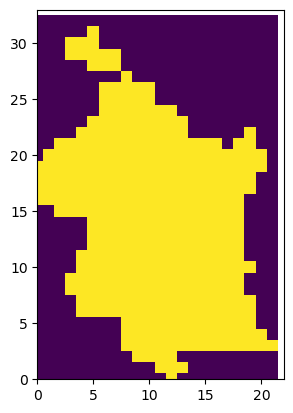

In [33]:
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyproj
from shapely.geometry import Point

crs_CERRA = '+proj=lcc +lat_0=50 +lat_1=50 +lat_2=50 +lon_0=8 +x_0=0 +y_0=0 +R=6371229 +units=m +no_defs'
crs_LATLONG = pyproj.Proj(proj='latlong', datum='WGS84').crs

df = gpd.read_file('../data/provinces.gpkg').to_crs(crs_CERRA)

df = df.loc[df['provincia'] == 'València/Valencia'] 
#df = df.loc[df['provincia'] == 'Badajoz'] 
xmin, ymin, xmax, ymax = df.total_bounds 

ds = xr.open_dataset("../data/1GB_reanalysis-cerra-single-levels.grib", engine="cfgrib")

transformer = pyproj.Transformer.from_crs(crs_LATLONG, crs_CERRA, always_xy=True) # ! xarray lib uses latlong crs as reference. We use crs_CERRA as reference system.
xGrid, yGrid = transformer.transform(ds.longitude.values, ds.latitude.values)

ds['longitude'] = (ds.longitude.dims, xGrid)
ds['longitude'].attrs['units'] = 'm'
ds['latitude'] = (ds.latitude.dims, yGrid)
ds['latitude'].attrs['units'] = 'm'

ds_bbox = ds.where(((xmin<= ds.longitude) & (ds.longitude <= xmax) & (ymin<= ds.latitude) & (ds.latitude <= ymax)),  drop=1) # Drop data asociated with points outside the bounding box

mask = np.zeros_like(ds_bbox.longitude.values, dtype=bool)
points =np.column_stack((ds_bbox.longitude.values.flatten(), ds_bbox.latitude.values.flatten()))

for x, y in points: 
    if df.geometry.contains(Point(x, y)).any():
        mask = np.logical_or(mask, (ds_bbox.longitude.values == x) & (ds_bbox.latitude.values == y))

ds_bbox = ds_bbox.where(mask) # ! Apply mask: Set to np.nan every metric asociated with points contained in the bounding box but not included in any geometry polygon
plt.imshow(mask, interpolation='nearest')

#plt.imshow(ds_bbox.r2.values[1]-273.15, interpolation='nearest') # > Print temperature as an example

plt.xlim(0, len(ds_bbox.x.values))
plt.ylim(0, len(ds_bbox.y.values)) # FIX: It does not start in zero (it prints in inverse order by default). 

# > Print example stats
data = []

for data_var in list(ds_bbox.data_vars):
    stats = {}

    stats['short_name'] = data_var 
    stats['standard_name'] = ds_bbox[data_var].attrs['standard_name'] 

    #stats['points'] = raster_dataset[data_var].shape[0]*raster_dataset[data_var].shape[1]*raster_dataset[data_var].shape[2]
    stats['time'] = ds_bbox[data_var].shape[0]
    stats['latitude'] = ds_bbox[data_var].shape[1]
    stats['longitude'] = ds_bbox[data_var].shape[2]
    stats['points'] = stats['time'] * stats['latitude'] * stats['longitude'] 

    stats['mean']   = round(float(ds_bbox[data_var].mean()), 2)
    stats['median'] = round(float(ds_bbox[data_var].median()), 2)
    stats['std']    = round(float(ds_bbox[data_var].std()), 2)
    stats['var']    = round(float(ds_bbox[data_var].var()), 2)    
    stats['max']    = round(float(ds_bbox[data_var].max()), 2)
    stats['min']    = round(float(ds_bbox[data_var].min()), 2)

    data.append(stats)


for stats in data:
    print(stats['standard_name']) 
    print(len(stats['standard_name']) *'-')
    for var in ['mean', 'median', 'std', 'var', 'max', 'min']:
        print(f'{var}: {str(round(float(stats[var]), 2))}')
    print('\n')

Relative humidity [%]
---------------------
mean: -194.85
median: -190.02
std: 17.51
var: 306.74
max: -173.15
min: -261.42


Temperature [C]
---------------
mean: 9.14
median: 8.99
std: 4.26
var: 18.11
max: 21.49
min: -2.28


Pressure [Pa]
-------------
mean: 96732.5
median: 96350.78
std: 3736.88
var: 13964281.17
max: 103449.56
min: 86372.33




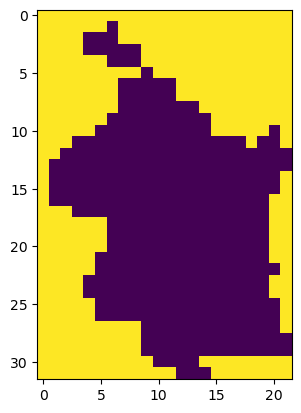

In [31]:
from osgeo import gdal, ogr, osr
from datetime import datetime
import re
import pyproj
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import time
import xarray as xr

def flatten_lists(nested_list):
    flattened_list = []
    stack = [nested_list]

    while stack:
        item = stack.pop()
        if len(item) == 2 and all(not isinstance(sub_item, list) for sub_item in item):
            flattened_list.append(item)  # Preserve the 2x2 list without flattening
        else:
            stack.extend(item[::-1]) 
    return flattened_list

desc_prov = 'València/Valencia'
crs_CERRA = '+proj=lcc +lat_0=50 +lat_1=50 +lat_2=50 +lon_0=8 +x_0=0 +y_0=0 +R=6371229 +units=m +no_defs'

gdb = ogr.GetDriverByName("GPKG").Open('../data/provinces.gpkg', 0) 
lyr = gdb.GetLayerByIndex(0) # Layer 0: Provinces
if desc_prov is not None: lyr.SetAttributeFilter(f"provincia='{desc_prov}'")

src = pyproj.CRS.from_string(lyr.GetSpatialRef().ExportToWkt())
dst = pyproj.CRS.from_proj4(crs_CERRA)
transform_to_ecmwf = pyproj.Transformer.from_crs(src, dst, always_xy=True)

bbox = {} # Bounding box
for feat in lyr:
    geom = feat.GetGeometryRef() # > type: osgeo.ogr.geometry
    points = flatten_lists(json.loads(geom.ExportToJson())['coordinates'])

    for point in points:
        x, y = transform_to_ecmwf.transform(point[0], point[1])

        if 'xmin' not in bbox or bbox['xmin'] > x: bbox['xmin'] = x
        if 'xmax' not in bbox or bbox['xmax'] < x: bbox['xmax'] = x
        if 'ymin' not in bbox or bbox['ymin'] > y: bbox['ymin'] = y
        if 'ymax' not in bbox or bbox['ymax'] < y: bbox['ymax'] = y

#lyr, bbox = self.read_geom_layer_bbox_gpkg()
raster = gdal.Open(f'../data/1GB_reanalysis-cerra-single-levels.grib')

transform = raster.GetGeoTransform()

xOrigin = transform[0]
yOrigin = transform[3]
pixelWidth = transform[1]
pixelHeight = transform[5]

# Specify offset and rows and columns to read
xoff = abs(int((xOrigin - bbox['xmin'])/pixelWidth))
yoff = int((yOrigin - bbox['ymax'])/pixelWidth)
xcount = int((bbox['xmax'] - bbox['xmin']) / pixelWidth)
ycount = abs(int((bbox['ymax'] - bbox['ymin']) / pixelWidth))

# Origin of new raster
x_lon_min = xoff * pixelWidth + xOrigin
y_lat_max = (yoff * pixelWidth - yOrigin) * -1

# Create memory target raster
target_ds = gdal.GetDriverByName('MEM').Create('', xcount, ycount, 1, gdal.GDT_Float32)
target_ds.SetGeoTransform((
    x_lon_min, pixelWidth, 0,
    y_lat_max, 0, pixelHeight,
))

target_ds.SetProjection(raster.GetProjection())
gdal.RasterizeLayer(target_ds, [1], lyr)
bandmask = target_ds.GetRasterBand(1)
datamask = bandmask.ReadAsArray(0, 0, xcount, ycount).astype(float)

raster_info = {}
for i in range(1, raster.RasterCount+1):
    band = raster.GetRasterBand(i)
    dataraster = band.ReadAsArray(xoff, yoff, xcount, ycount).astype(float)

    zoneraster = np.ma.masked_array(dataraster,  np.logical_not(datamask))
    zoneraster = np.ma.filled(zoneraster, np.nan)
    #zoneraster = zoneraster[~np.isnan(zoneraster)]
    
    if band.GetMetadata()['GRIB_COMMENT'] not in raster_info: raster_info[band.GetMetadata()['GRIB_COMMENT']] = []
    raster_info[band.GetMetadata()['GRIB_COMMENT']].append(zoneraster)

plt.imshow(np.logical_not(datamask), interpolation='nearest')

data = []

for key in raster_info:
    stats = {}
    zoneraster = np.array(raster_info[key]).flatten()

    stats['short_name'] = None 
    stats['standard_name'] = key
    
    stats['time'] = int(raster.RasterCount/len(raster_info))
    stats['latitude'] = int(target_ds.GetRasterBand(1).YSize)
    stats['longitude'] = int(target_ds.GetRasterBand(1).XSize) 
    stats['points'] = len(zoneraster)

    stats['mean']   = round(float(np.nanmean(zoneraster)), 2)
    stats['median'] = round(float(np.nanmedian(zoneraster)), 2)
    stats['std']    = round(float(np.nanstd(zoneraster)), 2)
    stats['var']    = round(float(np.nanvar(zoneraster)), 2)    
    stats['max']    = round(float(np.nanmax(zoneraster)), 2)
    stats['min']    = round(float(np.nanmin(zoneraster)), 2)

    data.append(stats)

for stats in data:
    print(stats['standard_name']) 
    print(len(stats['standard_name']) *'-')
    for var in ['mean', 'median', 'std', 'var', 'max', 'min']:
        print(f'{var}: {str(round(float(stats[var]), 2))}')
    print('\n')


relative_humidity
-----------------
mean: 78.11
median: 82.92
std: 17.66
var: 311.95
max: 100.0
min: 11.44


air_temperature
---------------
mean: 282.11
median: 281.96
std: 4.26
var: 18.12
max: 294.64
min: 269.63


surface_air_pressure
--------------------
mean: 96677.8
median: 96157.23
std: 3727.52
var: 13894422.0
max: 103715.71
min: 86459.48




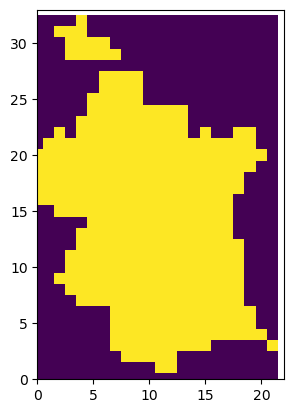

In [34]:
from osgeo import gdal, ogr, osr
from datetime import datetime
import re
import pyproj
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import time
import xarray as xr

ref_time = time.time()

def flatten_lists(nested_list):
    flattened_list = []
    stack = [nested_list]

    while stack:
        item = stack.pop()
        if len(item) == 2 and all(not isinstance(sub_item, list) for sub_item in item):
            flattened_list.append(item)  # Preserve the 2x2 list without flattening
        else:
            stack.extend(item[::-1]) 
    return flattened_list

### >  Input param
desc_prov = 'València/Valencia'
crs_CERRA = '+proj=lcc +lat_0=50 +lat_1=50 +lat_2=50 +lon_0=8 +x_0=0 +y_0=0 +R=6371229 +units=m +no_defs'

### > Load data and get metadata

gdb = ogr.GetDriverByName("GPKG").Open('../data/provinces.gpkg', 0) 
lyr = gdb.GetLayerByIndex(0) # Layer 0: Provinces
if desc_prov is not None: lyr.SetAttributeFilter(f"provincia='{desc_prov}'")

ds = xr.open_dataset("../data/1GB_reanalysis-cerra-single-levels.grib", engine="cfgrib")

ds = ds.assign_coords(longitude=(ds.longitude + 180) % 360 - 180)
ds = ds.assign_coords(latitude=(ds.latitude - 90) % 180 - 90)

src = pyproj.CRS.from_string('EPSG:4326') # lon/lat - https://epsg.io/4326
dst = pyproj.CRS.from_proj4(crs_CERRA)
transformer = pyproj.Transformer.from_crs(src, dst, always_xy=True)
xGrid, yGrid = transformer.transform(ds.longitude.values, ds.latitude.values)

ds['longitude'] = (ds.longitude.dims, xGrid)
ds['longitude'].attrs['units'] = 'm'
ds['latitude'] = (ds.latitude.dims, yGrid)
ds['latitude'].attrs['units'] = 'm'

src = pyproj.CRS.from_string(lyr.GetSpatialRef().ExportToWkt())
transform_to_ecmwf = pyproj.Transformer.from_crs(src, dst, always_xy=True)

bbox = {} # Bounding box
for feat in lyr:
    geom = feat.GetGeometryRef() # > type: osgeo.ogr.geometry
    points = flatten_lists(json.loads(geom.ExportToJson())['coordinates'])

    for point in points:
        x, y = transform_to_ecmwf.transform(point[0], point[1])

        if 'xmin' not in bbox or bbox['xmin'] > x: bbox['xmin'] = x
        if 'xmax' not in bbox or bbox['xmax'] < x: bbox['xmax'] = x
        if 'ymin' not in bbox or bbox['ymin'] > y: bbox['ymin'] = y
        if 'ymax' not in bbox or bbox['ymax'] < y: bbox['ymax'] = y


ds_bbox = ds.where(((bbox['xmin']< ds.longitude) & (ds.longitude < bbox['xmax']) & (bbox['ymin']< ds.latitude) & (ds.latitude < bbox['ymax'])),  drop=1) # Drop data asociated with points outside the bounding box
ycount, xcount =ds_bbox.latitude.shape 

pixelWidth = abs(round(ds.longitude.values[0][0]-ds.longitude.values[0][1], 3))
pixelHeight = round(ds.latitude.values[0][0]-ds.latitude.values[1][0], 3)

# Set projection
target_ds = gdal.GetDriverByName('MEM').Create('', xcount, ycount, 1, gdal.GDT_Float32)
target_ds.SetGeoTransform((
    np.min(ds_bbox.longitude.values), pixelWidth, 0,
    np.max(ds_bbox.latitude.values), 0, pixelHeight,
))

target_srs = osr.SpatialReference()
target_srs.ImportFromProj4(crs_CERRA)
target_ds.SetProjection(target_srs.ExportToWkt())
gdal.RasterizeLayer(target_ds, [1], lyr)
bandmask = target_ds.GetRasterBand(1)
mask = bandmask.ReadAsArray(0, 0, xcount, ycount).astype(bool)[::-1, :]

ds_bbox = ds_bbox.where(mask) 

plt.imshow(mask, interpolation='nearest')
plt.xlim(0, len(ds_bbox.x.values))
plt.ylim(0, len(ds_bbox.y.values)) # FIX: It does not start in zero (it prints in inverse order by default). 

data = []

for data_var in list(ds_bbox.data_vars):
    stats = {}

    stats['short_name'] = data_var 
    stats['standard_name'] = ds_bbox[data_var].attrs['standard_name'] 

    #stats['points'] = raster_dataset[data_var].shape[0]*raster_dataset[data_var].shape[1]*raster_dataset[data_var].shape[2]
    stats['time'] = ds_bbox[data_var].shape[0]
    stats['latitude'] = ds_bbox[data_var].shape[1]
    stats['longitude'] = ds_bbox[data_var].shape[2]
    stats['points'] = stats['time'] * stats['latitude'] * stats['longitude'] 

    stats['mean']   = round(float(ds_bbox[data_var].mean()), 2)
    stats['median'] = round(float(ds_bbox[data_var].median()), 2)
    stats['std']    = round(float(ds_bbox[data_var].std()), 2)
    stats['var']    = round(float(ds_bbox[data_var].var()), 2)    
    stats['max']    = round(float(ds_bbox[data_var].max()), 2)
    stats['min']    = round(float(ds_bbox[data_var].min()), 2)

    data.append(stats)

for stats in data:
    print(stats['standard_name']) 
    print(len(stats['standard_name']) *'-')
    for var in ['mean', 'median', 'std', 'var', 'max', 'min']:
        print(f'{var}: {str(round(float(stats[var]), 2))}')
    print('\n')

In [2]:
import os
import json
import matplotlib.pyplot as plt


def generate_images(file=None):
    # Ruta a la carpeta de logs
    logs_folder = '../logs'
    latest_json = file
    if file is None:
        json_files = [file for file in os.listdir(logs_folder) if file.endswith('.json')]
        latest_json = max(json_files)

    with open(os.path.join(logs_folder, latest_json)) as file:
        data = json.load(file)

    files = [(int(val.split('_')[0][:-2]), val.split('_')[0][-2:], val.split('_')[1]) for val in data.keys()]
    files.sort()

    stats = {}
    stats['x'] = [f[0] for f in files]

    for f in files:
        key = f'{f[0]}{f[1]}_{f[2]}'
        methods = data[key].keys() 

        for m in methods:
            time_to_finish = data[key][m].keys()
            if m not in stats : stats[m] = [] 
            stats[m].append(float(data[key][m]['crop_to_bbox_time']))


    for m in [m for m in stats if m != 'x']:
        plt.plot(stats['x'], stats[m], label =m)

    plt.xlabel('Tamaño del fichero (GB)')
    plt.ylabel('Tiempo de ejecución (s)')
    plt.title('Tiempo generación figura')

    plt.legend()

    plt.show()

    # > Time 

    stats = {}
    stats['x'] = [f[0] for f in files]

    for f in files:
        key = f'{f[0]}{f[1]}_{f[2]}'
        methods = data[key].keys() 

        for m in methods:
            time_to_finish = data[key][m].keys()
            if m not in stats : stats[m] = [] 
            stats[m].append(float(data[key][m]['extract_statistics_time']))


    for m in [m for m in stats if m != 'x']:
        plt.plot(stats['x'], stats[m], label =m)

    plt.xlabel('Tamaño del fichero (GB)')
    plt.ylabel('Tiempo de ejecución (s)')
    plt.title('Tiempo extracción de características')

    plt.legend()

    plt.show()

    # > Time 

    stats = {}
    stats['x'] = [f[0] for f in files]

    for f in files:
        key = f'{f[0]}{f[1]}_{f[2]}'
        methods = data[key].keys() 

        for m in methods:
            time_to_finish = data[key][m].keys()
            if m not in stats : stats[m] = [] 
            stats[m].append(float(data[key][m]['execution_time']))


    for m in [m for m in stats if m != 'x']:
        plt.plot(stats['x'], stats[m], label =m)

    plt.xlabel('Tamaño del fichero (GB)')
    plt.ylabel('Tiempo de ejecución (s)')
    plt.title('Tiempo total de ejecución')

    plt.legend()

    plt.show()


generate_images()


ValueError: max() arg is an empty sequence